# 2022-01-11b Improved Euler time-stepping

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have noted previously (2021-08-27 diary notes) that one reason the `oVAoBE*` models do not exhibit early pedestrian crossing in front of a decelerating vehicle in my simulations, has been that due to numerical imprecision with the 0.1 s time step, the yielding car in the `PedCrossVehYield` scenario tends to stop earlier than assumed by the pedestrian's assumed passing-second behaviour for the vehicle. This, in turn, causes the pedestrian to think that the car will progressively reduce its passing-second deceleration, such that in practice a prediction interval $T_p$ into the future it always looks as if the car will still be moving, which in turn makes it look scary for the `oVABE*` model to pass in front of it, right up until the car has actually stopped. As I discussed in the 2021-08-27 notes, this seems like an undesirable property of the `oVAoBE*` model, in that it makes it sensible to exactly how the car decelerates, so for that reason I didn't try to fix this by getting the yielding deceleration to align with the model's behaviour expectation; I instead pursued the `oVAaoBE*` models. However, since those models turn out to have a number of other problems, I now thought that it would be sensible to return to this matter. Basically I can accept that it is a shortcoming of the current framework that it doesn't have any flexibility in how agents assume that others will achieve their passing first/second behaviours. Real humans might be much more flexible, and might do something which could for example be modelled as a kind of Kalman filtering of acceleration - but that can be left outside of the modelling scope here.

More specifically, the numerical imprecision in my previous implementation was due to `commotions.get_future_kinematic_state()`, which did not include an acceleration term in the position update, but now I have added that term.

Below we can see that this does indeed fix the problem - `oVAoBE*` now achieves quite human-like early pedestrian crossing. Further below I also run through some of the usual unit tests, which confirm that the time-stepping modifications does make a difference to model behaviour, mostly quite subtly so, but in some cases more noticeable.

As part of this update I have also changed the early-crossing metric (`sc_fitting.metric_veh_speed_at_ped_start()`) to look at vehicle speed at first pedestrian non-zero speed, rather than when the pedestrian is halfway to the conflict space - because even if the pedestrian starts early the vehicle might have made it to zero speed by that time.

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

# imports needed to run the simulations
import math
import copy
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType
import sc_fitting

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']


## Now `oVAoBE*` does achieve quite human-like early pedestrian crossing

The below can be compared for example to the results in the 2022-01-02b notes. 

We see that `oVA` still waits until the vehicle comes to a complete stop before beginning to cross, whereas `oVAoBEvoAI` (with the parameterisation tested in the 2022-01-02b notes) crosses about 0.5 s earlier, which is quite similar to our HIKER results. The `oVAaoBEvoAI` (again with the same parameterisation) crosses much earlier. 

*** Model oVA ***


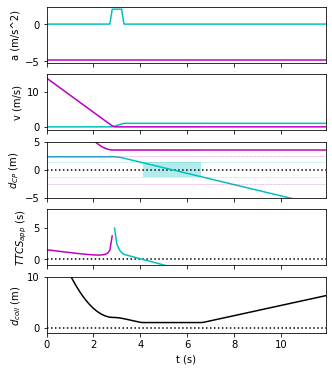

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0


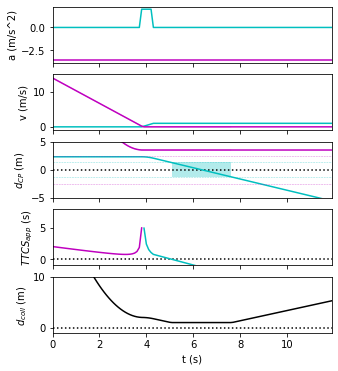

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0


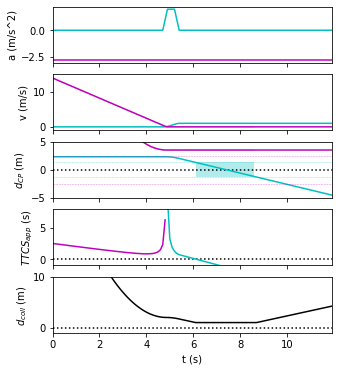

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0

*** Model oVAoBEvoAI ***


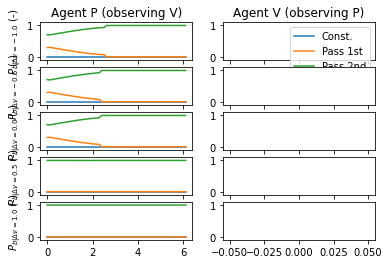

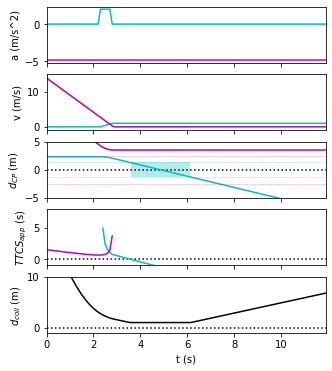

Metric PedCrossVehYield_veh_speed_at_ped_start = 2.217553688141919


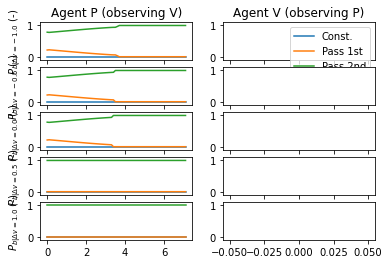

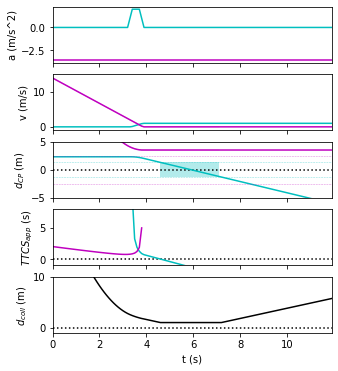

Metric PedCrossVehYield_veh_speed_at_ped_start = 1.6424619640387381


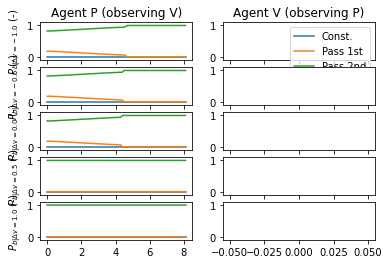

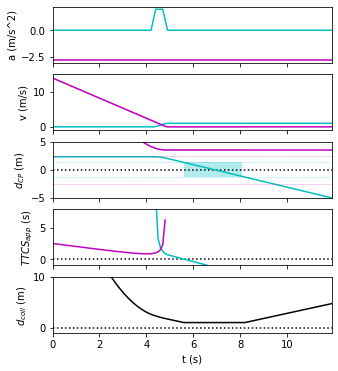

Metric PedCrossVehYield_veh_speed_at_ped_start = 1.3042284459088274

*** Model oVAaoBEvoAI ***


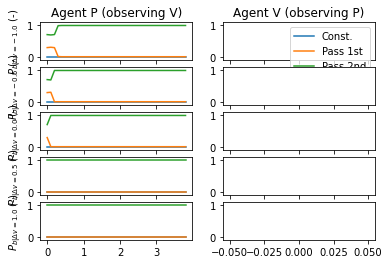

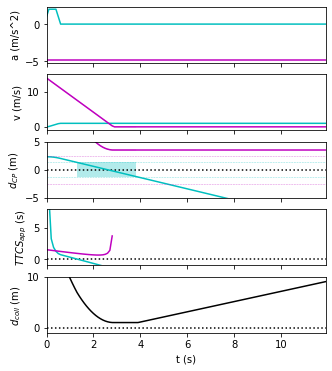

Metric PedCrossVehYield_veh_speed_at_ped_start = 13.402583255524432


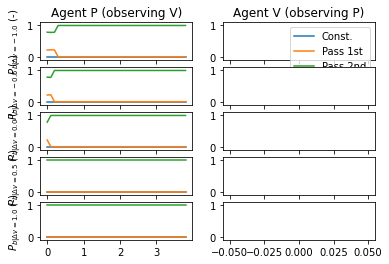

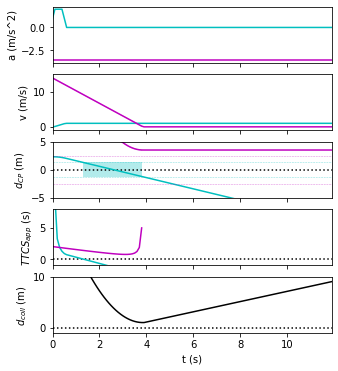

Metric PedCrossVehYield_veh_speed_at_ped_start = 13.528699861687414


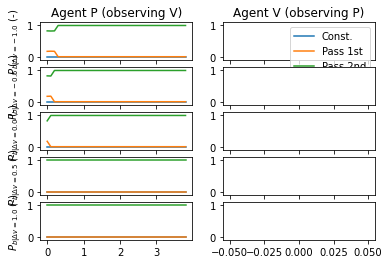

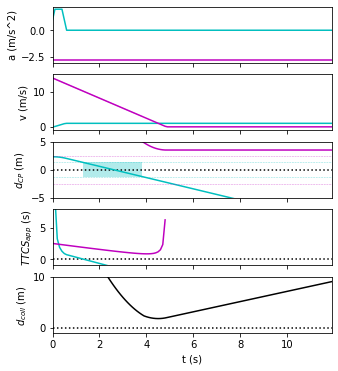

Metric PedCrossVehYield_veh_speed_at_ped_start = 13.60287387882116



In [2]:
def run(i_variation = 0, snapshots=(None, None), detailed_snapshots=False, plot_veh_stop_dec=False, end_time=12):
    scenario.end_time = end_time
    sim = sc_fitting.construct_model_and_simulate_scenario(model, params_dict, scenario,
                                                           i_variation=i_variation, 
                                                           apply_stop_criteria=False,
                                                           snapshots=snapshots,
                                                           detailed_snapshots=detailed_snapshots,
                                                           report_time=True)
    sim.do_plots(kinem_states=True, beh_probs=('oBE' in model), beh_activs=False, 
                  action_val_ests=False, surplus_action_vals=False, looming=False,
                  veh_stop_dec=plot_veh_stop_dec)
    metrics = sc_fitting.get_metrics_for_scenario(scenario, sim, verbose=True)
    if plot_veh_stop_dec:
        veh_agent = sim.agents[sc_fitting.i_VEH_AGENT]
        print(f'Final vehicle distance to conflict space: {veh_agent.signed_CP_dists[-1] - veh_agent.coll_dist} m')

for model in ('oVA', 'oVAoBEvoAI', 'oVAaoBEvoAI'):
    print(f'*** Model {model} ***')
    params_dict = {'T_delta': 59.95, 'beta_V': 18.98}
    scenario = sc_fitting.ONE_AG_SCENARIOS['PedCrossVehYield']
    for i_variation in range(scenario.n_variations):
        run(i_variation=i_variation)
    print()

## Unit tests, reproducing earlier results

### Basics - only quite minor changes

Just the base model, no interaction. No changes since 2021-12-13

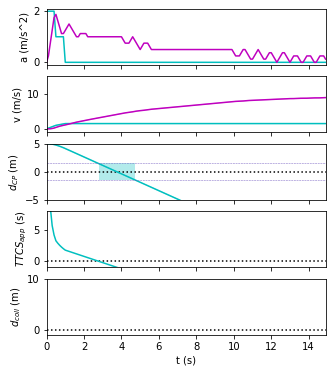

In [3]:
NAMES = ('P', 'V')
WIDTHS = (1.5, 1.5) # setting widths/lengths corresponding to the old default
LENGTHS = (1.5, 1.5) # setting sc_scenario.SHARED_PARAMS.d_C = 1.5
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = sc_scenario.SCSimulation(
        CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. 

Some differences from 2021-12-13, especially notable in the 50 m scenario.

Initial car distance 30 m:


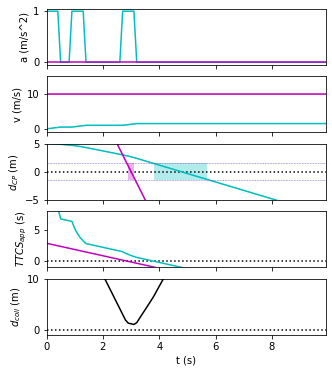

Initial car distance 40 m:


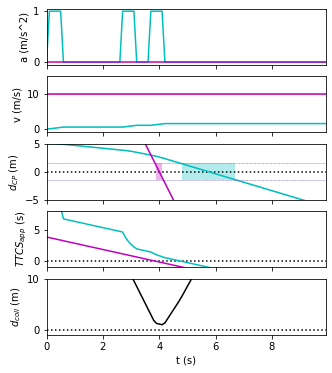

Initial car distance 50 m:


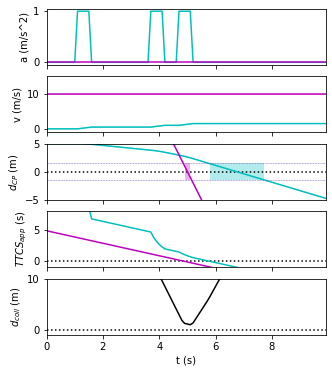

In [4]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), 
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. 

Again some minor differences from 2021-12-13, but quite subtle.

Initial car distance 30 m:


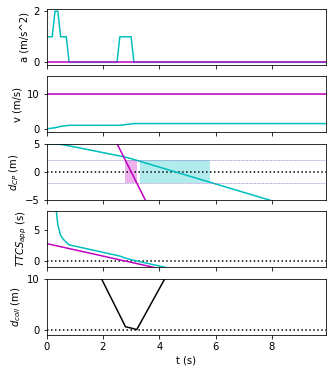

Initial car distance 40 m:


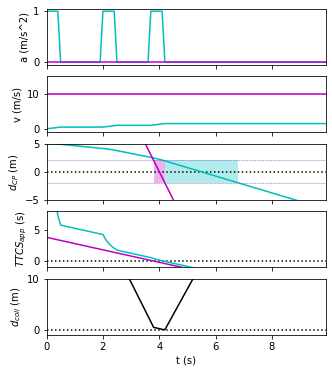

Initial car distance 50 m:


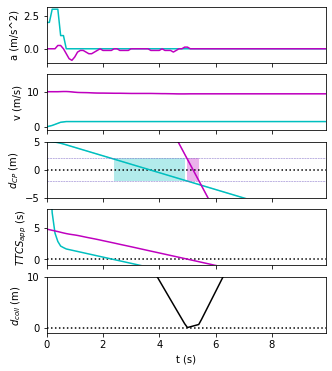

In [5]:
WIDTHS = (2, 2) # setting widths/lengths corresponding to the old default
LENGTHS = (2, 2) # setting sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### Testing the `oBEo` etc sequence - also mostly subtle changes but some more noticeable

In its currently default form, this sequence again shows only quite subtle changes since 2021-12-13.

Turning on oBEo:
Initial car distance 40 m:


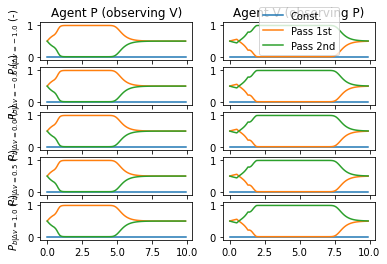

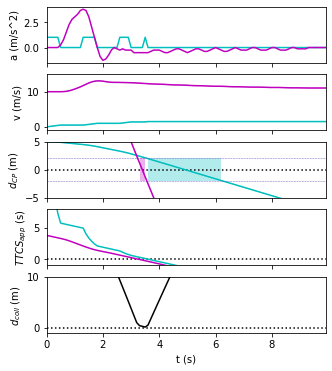

Turning on oBEv:
Initial car distance 40 m:


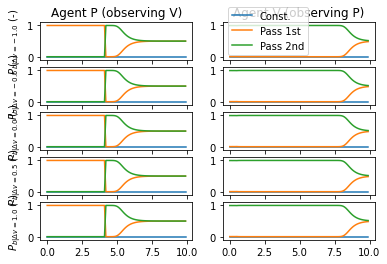

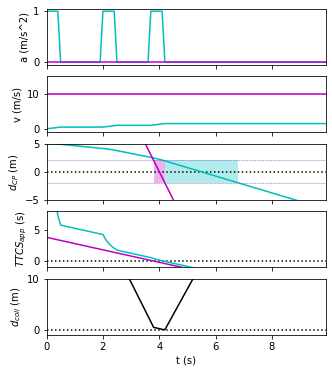

Turning on oAI:
Initial car distance 40 m:


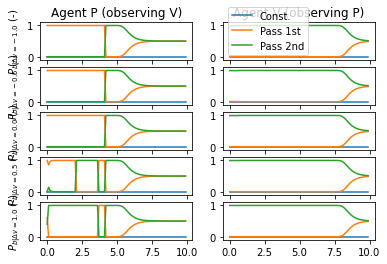

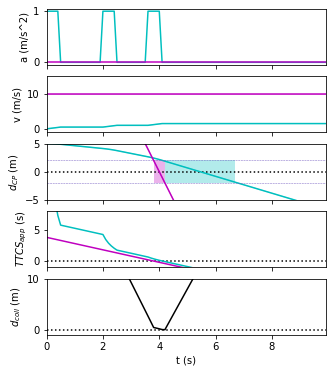

In [6]:
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

def run_oBEo_etc_seq():
    global optional_assumptions
    print('Turning on oBEo:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oBEv:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oAI:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
run_oBEo_etc_seq()

However, when I turn off the new access order implication calculations, I no longer get back the old results, familiar from 2021-11-29b and earlier. (I have confirmed that when I restore the old Euler forward stepping, from before today, I get back the same results as 2021-12-13 below, so it's clearly the new Euler forward stepping that is making the difference.)

Base model (with old access order implication calculations):
Initial car distance 40 m:


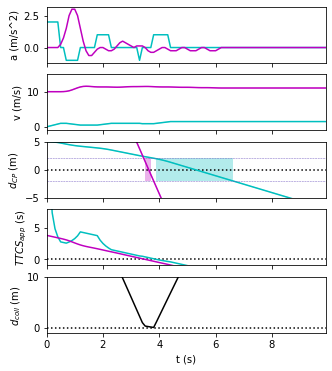

Turning on oBEo:
Initial car distance 40 m:


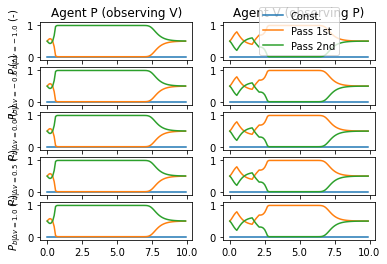

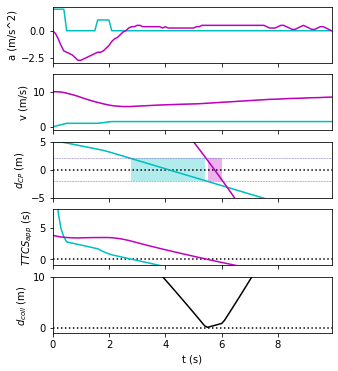

Turning on oBEv:
Initial car distance 40 m:


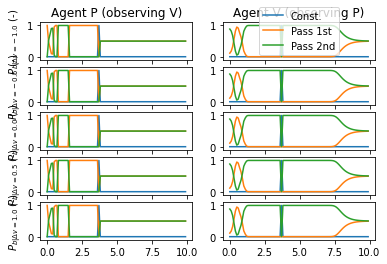

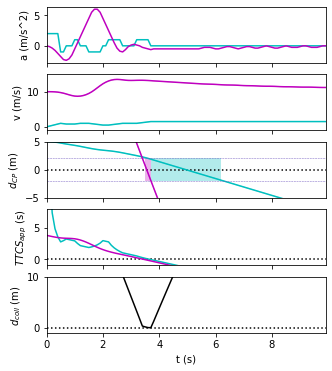

Turning on oAI:
Initial car distance 40 m:


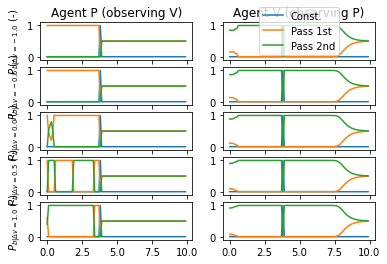

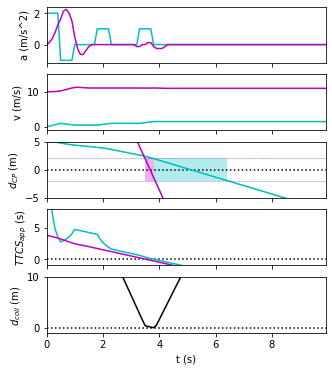

In [7]:
import sc_scenario_helper
sc_scenario_helper.NEW_ACC_IMPL_CALCS = False

print('Base model (with old access order implication calculations):')
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN)
run_baseline_kinematics(dist0s = (40,))
run_oBEo_etc_seq()